# Fine Foods - Data Overview & Text Analysis
We will be using food reviews from Amazon to build a recommendation engine using Factorization Machine in SAS VIYA

Factorization Machine (FM) is one of the newest algorithms in the Machine Learning space, and has been developed in SAS. FM is a general prediction algorithm, similar to Support Vector Machines, that can model very sparce data, an area where traditional Machine Learning techniques fail. 

Since FM is a general prediction algorithm, it can accept any sized real vector as inputs. Because of this, we will use SAS Viya text analytics capabilities to represent text as numeric vectors, that we can use as inputs to our FM model.


this notebook has **three** parts:
1. Load Data &  Prepare Notebook
2. Data overview & manipulation
3. Perform Text Analytics
4. Promote dataset to public memory 

We will use the dataset promoted to public memory to train our FM model in SAS Studio

## 1. Load Data
In this step, we will make a connection to our CAS server, and will load the revelant table that we prepared in Python into memory


In [53]:
from swat import *
import _config
%matplotlib inline
#swat.options.cas.print_messages = False

# Connect to the session
cashost='gtpviyaea12.unx.sas.com'
casport=5570
user,pswd = _config.login()

s = CAS(cashost, casport, user, pswd)

# Create a CAS library called DMLib pointing to the defined directory
## Note, need to specify the srctype is path, otherwise it defaults to HDFS
s.table.addCaslib(datasource={'srctype':'path'}, name='DMlib', path="/viyafiles/ankram/Data");

#Load Data
f = 'foods_prepped'
s.loadTable(caslib='DMlib', path=f +'.csv', casout=f);

#Load actionsets
actionsets=['fedSQL', 'autoTune', 'factMac', 'textMining']
[s.builtins.loadactionset(i) for i in actionsets];

#Create shortcuts
food = s.CASTable(f)
target = 'score'
class_inputs = ['helpfulness','productid','time','userid']

NOTE: 'DMlib' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'DMlib'.
NOTE: Cloud Analytic Services made the file foods_prepped.csv available as table FOODS_PREPPED in caslib DMlib.
NOTE: Added action set 'fedSQL'.
NOTE: Added action set 'autoTune'.
NOTE: Added action set 'factMac'.
NOTE: Added action set 'textMining'.


## 2. Overview Data & Manipulation
In this step, we will take a look at the data presented to us. We notice that this dataset contains the variables "productId", "userid", and "score". This is the most basic information required to build a recommender system through traditional collaborative filtering methodologies.

While traditional collaborative filtering methods are powerful in their prediction abilities, they are severely restricted by the input vector requirements, typically taking only two inputs - user and item. With factorization machine, we can enrich our models by having a much wider input vector containing more than two inputs. We can see if "Time" and "helpfulness" can make our engine more accurate.

Lastly, each user has some amount of free form text. By using text mining capabilities in Viya, we can summarize the text into topics, which we can then include in our factorization machine model.


In the cell below, we will just need to add an id column with the datastep to tell SAS that each row represents one document

In [54]:
s.CASTable('foods_prepped').head()

,helpfulness,productId,score,summary,text,time,userId
0,2/2,B001NXM3GM,5.0,Great nutritious snack!,My son loves these puffs... they do have a bla...,1.297382e+09,A198382LAIX7H7
1,2/2,B001NXM3GM,5.0,"Meets baby's approval, hence it met ours","Simply put, my daughter has decided to stuff a...",1.290643e+09,AQXJM6TILVEDY
2,2/2,B001NXM3GM,5.0,Great finger food for babies,"I purchased these because they are organic, ha...",1.262563e+09,A2X0DBSC4SE7WI
3,4/5,B001NXM3GM,5.0,Can't Get Enough Of Those Puffs!,My baby is in love with these puffs. When we b...,1.247702e+09,AMDREWLSOT8ID
4,1/1,B001NXM3GM,4.0,Satisfied.,I read a review that said some will have almos...,1.348358e+09,AHK9Z99W9UQE0


In [55]:
#Print Number of reviews
print(len(food), "Reviews")

#Validate first few rows
food.head()

#Add a column Identifier in-memory
s.dataStep.runCode('''
    data ''' + f + '''; 
        set '''  + f + ''';
        key = _n_;
    run;,
    
    single=YES,
    replace=YES
''')

#Validate first few rows
food.head(5)

568454 Reviews


,helpfulness,productId,score,summary,text,time,userId,key
0,0/0,B00817GPWQ,1.0,Terrible waste of chocolate and raspberry flavors,I LOVE chocolate and adore raspberries (Godiva...,1.301184e+09,ATXDX08LIQLS,1389.0
1,0/0,B00817GPWQ,2.0,I don't give a hoot about Van Houtte,I tried several brands and definitely prefer t...,1.300925e+09,A3FPCS4N1SAL91,1390.0
2,0/0,B00817GPWQ,5.0,Delicious !,If you love chocolate truffles and raspberries...,1.300925e+09,A1CEQYKHBAYAJ9,1391.0
3,0/0,B00817GPWQ,3.0,Not bold enough,I love bold strong flavors and this is not qui...,1.300666e+09,A3NWJPIRABJXX3,1392.0
4,0/0,B00817GPWQ,3.0,False Information,"A while back, I ordered this product, and when...",1.300406e+09,A291Q9GA11R0SH,1393.0


## 3. Perform Text Analysis
The code below performs text analytics on the free form reviews, generating the following:
1. Creating Document term matrix
2. Creating parent-child relationshipos
3. Text Topics and important terms per topic
4. Creating structured representation of the text data

For this FM model, we will look to reduce the document term matrix into different topics. We will derive both topic membership, and the three structured representations (svd projections), to describe latent differences amoung the free form text data. We will use these numeric vectors, in additional to our original inputs, in our FM model
<br>

We will start out by generating 25 text topics, and will look at the scree plot to try to determine the number of topics

In [5]:
#Load stop list into memory
s.loadTable(caslib='DMlib', path='engstop'+'.sas7bdat', casout='engstop');

#Helper function to aid with text mining
def c_dict(name):
    training_options = dict(name      = name,
                            replace   = True)                           
    return training_options

#Perform Text mining
    #* = optional
s.textMining.tmMine(
  documents=f,
  stopList="engstop",
  docId="key",
  copyVars=class_inputs + [target],
  text='text',
  reduce=10,
  entities="STD",
  k=25,
  norm="DOC",
  #u=c_dict("svdu"),
  s=c_dict("singular_values"),
  terms=c_dict("terms"), 
  #parent=c_dict("parent"), 
  #child=c_dict("child"), 
  #parseConfig=c_dict("config"), 
  docPro=c_dict("docpro"), 
  topics=c_dict("topics"), 
)

NOTE: Cloud Analytic Services made the file engstop.sas7bdat available as table ENGSTOP in caslib DMlib.


,casLib,Name,Label,Rows,Columns,casTable
0,DMlib,terms,,141735,11,"CASTable('terms', caslib='DMlib')"
1,DMlib,singular_values,,25,2,"CASTable('singular_values', caslib='DMlib')"
2,DMlib,docpro,,568454,31,"CASTable('docpro', caslib='DMlib')"
3,DMlib,topics,,25,3,"CASTable('topics', caslib='DMlib')"


### Determine Topics
After running our model. We must determine an appropriate number of topics that can best represent this free form data. Looking at the scree plot will help us. We do not see much gain after the 5th singular value, so we will choose 5 topics here

Selected Rows from Table SINGULAR_VALUES

   _Id_         _S_
0   1.0  273.859753
1   2.0   80.208209
2   3.0   69.104644
3   4.0   48.678744
4   5.0   45.864780
5   6.0   42.246227
6   7.0   40.930320
7   8.0   40.573426
8   9.0   39.016737
9  10.0   38.492832


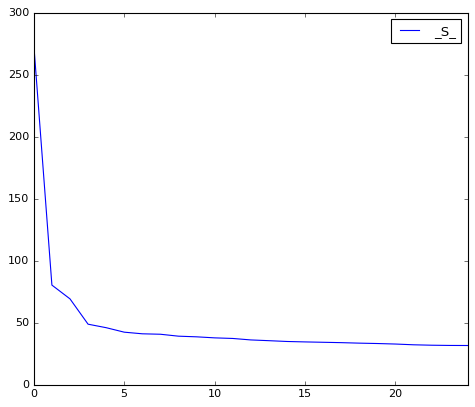

In [12]:
s.CASTable('singular_values')['_S_'].plot(figsize = (7, 6))
print(s.CASTable('singular_values').head(10))

In [17]:
s.CASTable('docpro').head()

,key,_Col1_,_Col2_,_Col3_,_Col4_,_Col5_,_Col6_,_Col7_,_Col8_,_Col9_,...,_Col21_,_Col22_,_Col23_,_Col24_,_Col25_,helpfulness,productId,time,userId,score
0,4613.0,0.595421,0.025581,0.102683,0.208546,0.114937,0.116232,0.224990,0.080995,0.138474,...,0.186115,0.120984,0.182582,0.127139,0.050240,1/1,B001ACMCLM,1.260576e+09,A1PN6C3A3OLUKU,5.0
1,4614.0,0.583595,0.055310,0.105170,0.193666,0.128937,0.120817,0.168404,0.096675,0.090595,...,0.210300,0.124802,0.195207,0.105048,0.076388,0/0,B001ACMCLM,1.351210e+09,A2PCNXBSKCABG5,4.0
2,4615.0,0.383286,0.089778,0.084521,0.153799,0.198643,0.200401,0.176481,0.116134,0.060141,...,0.289838,0.196229,0.091990,0.052942,0.137483,0/0,B001ACMCLM,1.325981e+09,A2KSO2JHIASBSW,5.0
3,4616.0,-0.002195,0.041620,0.076334,0.063349,0.342362,0.127223,0.047770,0.164086,0.041967,...,0.161381,0.178474,-0.058576,0.709005,0.238341,9/9,B0018CG2MO,1.308614e+09,AFNCXMCX7VZWH,4.0
4,4617.0,0.307733,0.099406,0.135891,0.166759,0.100566,0.284390,0.354780,0.192421,0.157970,...,0.191647,0.230405,0.128474,0.066491,0.090521,3/3,B0018CG2MO,1.285200e+09,A1XHFBJTBTPOV0,5.0


### Re run text mining model
We will re run the model with 5 topics. We will examine the topic membership and the words that make up each topic

In [56]:
#Load stop list into memory
s.loadTable(caslib='DMlib', path='engstop'+'.sas7bdat', casout='engstop');

#Re Run text mining
s.textMining.tmMine(
  documents=f,
  stopList="engstop",
  docId="key",
  #copyVars=class_inputs + [target],
  text='text',
  reduce=10,
  entities="STD",
  k=5,
  norm="DOC",
  s=c_dict("singular_values"),
  topicDecision=True, 
  docPro=c_dict("docpro"), 
  topics=c_dict("topics"), 
)

#Topic Membership (Binary 1/0 and structured representation)
s.CASTable("docpro").head()

NOTE: Cloud Analytic Services made the file engstop.sas7bdat available as table ENGSTOP in caslib DMlib.


,key,_Col1_,_Col2_,_Col3_,_Col4_,_Col5_,_TextTopic_1,_TextTopic_2,_TextTopic_3,_TextTopic_4,_TextTopic_5
0,5625.0,-0.521922,0.207558,0.447586,0.494187,0.489860,0.0,0.0,0.0,0.0,0.0
1,5626.0,-0.242744,0.271329,0.395012,0.762278,0.361046,0.0,0.0,0.0,0.0,0.0
2,5627.0,-0.540025,0.269372,0.391032,0.556601,0.416054,0.0,0.0,0.0,0.0,0.0
3,5628.0,-0.369360,0.176239,0.467510,0.557075,0.551013,0.0,0.0,0.0,0.0,0.0
4,5629.0,0.067351,0.063768,0.988944,0.040563,0.108364,0.0,0.0,0.0,0.0,0.0


In [63]:
s.fedSQl.execDirect('''create table testing as select sum(_TextTopic_1) from docpro''')

NOTE: Table TESTING was created in caslib DMlib with 1 rows returned.


+ Elapsed: 0.258s, user: 0.141s, sys: 0.163s, mem: 32.4mb

In [64]:
s.CASTable('testing').head()

,SUM
0,0.0


In [57]:
#See topics
s.CASTable("topics").head()

,_TopicId_,_Name_,_Category_,_NumTerms_,_NumDocs_,_TermCutOff_,_DocCutOff_
0,1.0,"science diet, science, diet, supplement, vitamin",Mult,0.0,0.0,0.005,14.964
1,2.0,"magnesium, rda, almonds, bowel tolerance, almonds",Mult,0.0,0.0,0.004,6.448
2,3.0,"science diet, deliberately, 50 percent, diet, ...",Mult,0.0,0.0,0.004,8.797
3,4.0,"vitamin, supplement, +acid, dried, hydrochloride",Mult,0.0,0.0,0.005,12.042
4,5.0,"+byproduct, aka, purina, +trash, unsuspecting ...",Mult,0.0,0.0,0.004,10.244


## 4. Promote Text Analytics Dataset into public memory
We will first take a look at the dataset ouput from our text analytics. We can see 3 columns have been added, _Col1_, _Col2_, _Col3_. These columns are the numerical summaries of how each text review is related to each of the 3 latent text topics
<br>

We will then promote this dataset into public memory, where we will use it to build a FM model in SAS Studio. Alternatively, you could save the file to the server as a sashdat file, and load it into memory in SAS Studio

In [33]:
food.columns

Index(['helpfulness', 'productId', 'score', 'summary', 'text', 'time',
       'userId', 'key'],
      dtype='object')

In [36]:
s.fedSql.execDirect('''
    CREATE TABLE Foods_Prep_Text AS
    SELECT t1.helpfulness,
           t1.productId,
           t1.score,
           t1.summary,
           t1.text,
           t1.time,
           t1.userId,
           t2.*
    FROM foods_prepped t1
    INNER JOIN docpro t2
    ON t1.key=t2.key''')

s.CASTable('Foods_Prep_Text').head()

NOTE: Table FOODS_PREP_TEXT was created in caslib DMlib with 45371970 rows returned.


,helpfulness,productId,score,summary,text,time,userId,key,_Col1_,_Col2_,_Col3_,_Col4_,_Col5_,_TextTopic_1,_TextTopic_2,_TextTopic_3,_TextTopic_4,_TextTopic_5
0,0/0,B0029NTXTA,5.0,Tempted my 14 year 8 mo old dog to eat!,"I tried some of this on my old guy, an America...",1.329869e+09,A2HUJA5N4TVC2F,1401.0,-0.678379,0.258631,0.368541,0.373837,0.444224,0.0,0.0,0.0,0.0,0.0
1,0/0,B0029NTXTA,5.0,Tempted my 14 year 8 mo old dog to eat!,"I tried some of this on my old guy, an America...",1.329869e+09,A2HUJA5N4TVC2F,1401.0,-0.678379,0.258631,0.368541,0.373837,0.444224,0.0,0.0,0.0,0.0,0.0
2,0/0,B0029NTXTA,5.0,Tempted my 14 year 8 mo old dog to eat!,"I tried some of this on my old guy, an America...",1.329869e+09,A2HUJA5N4TVC2F,1401.0,-0.678379,0.258631,0.368541,0.373837,0.444224,0.0,0.0,0.0,0.0,0.0
3,0/0,B0029NTXTA,5.0,Tempted my 14 year 8 mo old dog to eat!,"I tried some of this on my old guy, an America...",1.329869e+09,A2HUJA5N4TVC2F,1401.0,-0.678379,0.258631,0.368541,0.373837,0.444224,0.0,0.0,0.0,0.0,0.0
4,0/0,B0029NTXTA,5.0,Tempted my 14 year 8 mo old dog to eat!,"I tried some of this on my old guy, an America...",1.329869e+09,A2HUJA5N4TVC2F,1401.0,-0.678379,0.258631,0.368541,0.373837,0.444224,0.0,0.0,0.0,0.0,0.0


In [45]:
s.CASTable('foods_prep_text').dtypes

helpfulness     varchar
productId       varchar
score            double
summary         varchar
text            varchar
time             double
userId          varchar
key              double
_Col1_           double
_Col2_           double
_Col3_           double
_Col4_           double
_Col5_           double
_TextTopic_1     double
_TextTopic_2     double
_TextTopic_3     double
_TextTopic_4     double
_TextTopic_5     double
dtype: object

In [ ]:
len(s.CASTable('foods_prep_text'))

In [7]:
#Load data into Public memory
#s.loadTable(caslib='DemoData',  path='Foods_prep_text'+'.sashdat', casout='docpro')

NOTE: Cloud Analytic Services made the file Foods_prep_text.sashdat available as table DOCPRO in caslib CASUSER(sasdemo).


[caslib]

 'CASUSER(sasdemo)'

[tableName]

 'DOCPRO'

[casTable]

 CASTable('DOCPRO', caslib='CASUSER(sasdemo)')

+ Elapsed: 0.542s, user: 0.003s, sys: 0.017s, mem: 0.14mb

In [15]:
#Load data into Public memory
#s.table.promote(table='docpro')

#Save file to Server
s.table.save(caslib='DemoData', name='Foods_prep_text.sashdat', table="docpro", replace=True)

NOTE: Cloud Analytic Services saved the file Foods_prep_text.sashdat in caslib DemoData.


[caslib]

 'DemoData'

[name]

 'Foods_prep_text.sashdat'

+ Elapsed: 0.426s, user: 0.026s, sys: 0.089s, mem: 16.1mb

In [ ]:
s.loadTable(caslib='DMlib', path='Foods_prep_text.sashdat', casout='test');

s.CASTable('test').head()


In [52]:
s.close()